In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt 
from diffrax import diffeqsolve, ODETerm, SaveAt, Tsit5

# Lotka-Volterra Equations

$$
\begin{aligned}
& \frac{dx}{dt} = \alpha x - \beta xy  \\
& \frac{dy}{dt} = \delta xy - \gamma y 
\end{aligned}
$$

In [16]:
def vector_field(t, y, args):
    prey, predator = y 
    alpha, beta, gamma, delta = args 
    d_prey = alpha * prey - beta * prey * predator
    d_predator = delta * prey * predator - gamma * predator 
    d_y = d_prey, d_predator 
    return d_y 

In [17]:
term = ODETerm(vector_field)
solver = Tsit5()
t0, t1 = 0, 140 
dt0 = 0.1 
y0 = (10.0, 10.0)
args = (0.1, 0.02, 0.4, 0.02)
saveat = SaveAt(ts=jnp.linspace(t0,t1, 1000))
sol = diffeqsolve(term, solver, t0, t1, dt0, y0, args=args, saveat=saveat)

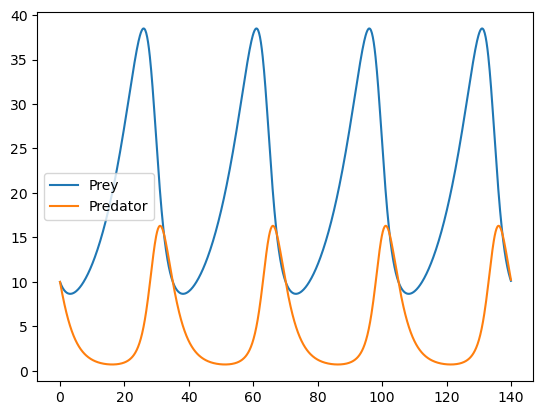

In [18]:
plt.plot(sol.ts, sol.ys[0], label="Prey")
plt.plot(sol.ts, sol.ys[1], label="Predator")
plt.legend()
plt.show()

# Lorenz System

$$
\begin{aligned}
& \frac{dx}{dt} = \sigma(y-x)\\
& \frac{dy}{dt} = x(\rho - z) - y \\ 
& \frac{dz}{dt} = xy - \beta z 
\end{aligned}
$$

In [29]:
def vector_field(t, y, args):
    x_,y_,z_ = y
    sigma, rho, beta = args
    dxdt = sigma * (y_ - x_)
    dydt = x_ * (rho - z_) - y_
    dzdt = x_ * y_ - beta * z_
    dstate = dxdt, dydt, dzdt 
    return dstate

In [63]:
term = ODETerm(vector_field)
solver = Tsit5()
t0, t1 = 0, 10
dt0 = 0.01 
y0 = (5.0, 5.0, 5.0)
args = (10, 28, 8/3)
saveat = SaveAt(ts=jnp.linspace(t0,t1, 500))
sol = diffeqsolve(term, solver, t0, t1, dt0, y0, args=args, saveat=saveat)

In [64]:
y1 = (5.1, 5.0, 5.0)
sol2 = diffeqsolve(term, solver, t0, t1, dt0, y1, args=args, saveat=saveat)

In [65]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [68]:
# plot the two attractors 
def plot_attractor(y1, y2):
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(projection = '3d')
    ax.plot(y1[0], y1[1], y1[2], label="Traj1")
    ax.plot(y2[0], y2[1], y2[2], label="Traj2")
    ax.legend()
    plt.title("Lorenz Attractor")
    plt.show()

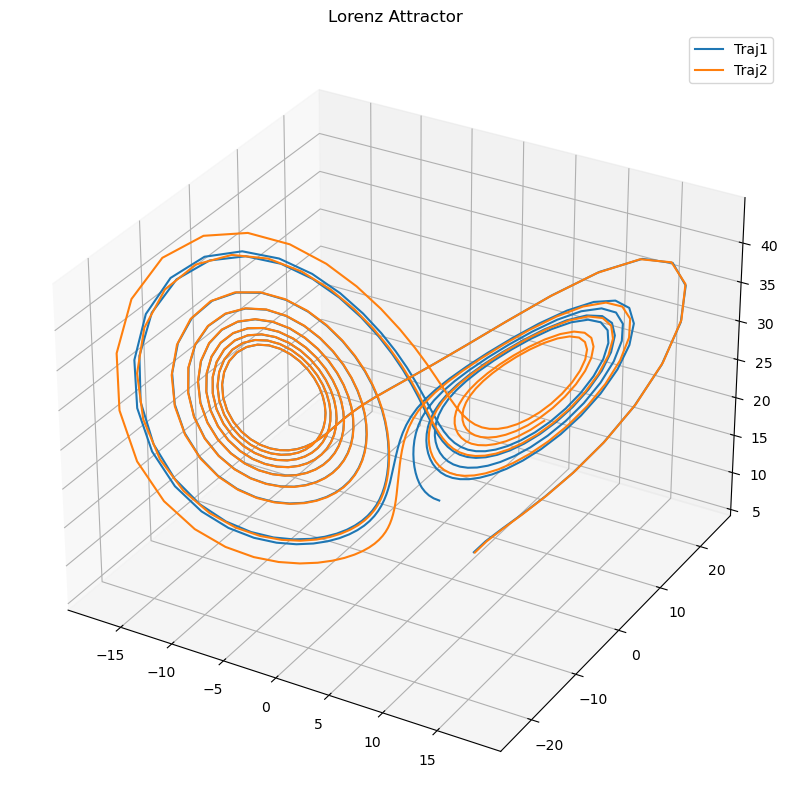

In [69]:
plot_attractor(sol.ys, sol2.ys)

# Stochastic Lorenz Attractor

$$
\begin{aligned}
& y \sim \mathcal{N}(0, I_{3\times 3})\\
& dx = \sigma_1(y-x) dt + \sigma_2 x dw(t)\\
& dy = (x(\rho_1 - z) - y)dt + \rho_2 y dw(t) \\ 
& dz = (xy - \beta_1 z)dt + \beta_2 z dw(t) 
\end{aligned}
$$

In [78]:
# same lorenz vector field as above
def vector_field(t, y, args):
    x_, y_, z_ = y
    sigma, rho, beta = args.sigma1, args.rho1, args.beta1
    dxdt = sigma * (y_ - x_)
    dydt = x_ * (rho - z_) - y_
    dzdt = x_ * y_ - beta * z_
    dstate = dxdt, dydt, dzdt 
    return dstate

In [86]:
def diffusion_field(t, y, args):
    x_, y_, z_ = y 
    sigma, rho, beta = args.sigma2, args.rho2, args.beta2
    dxdt = sigma * x_ 
    dydt = rho * y_
    dzdt = beta * z_ 
    dwdt = dxdt, dydt, dzdt
    return dwdt

In [87]:
class Args(object):
    def __init__(self, sigma1, sigma2, 
                 rho1, rho2, beta1, beta2):
        self.sigma1 = sigma1 
        self.sigma2 = sigma2 
        self.rho1 = rho1 
        self.rho2 = rho2
        self.beta1 = beta1 
        self.beta2 = beta2 

In [136]:
# import jax.random as jr 
# from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm,ODETerm, SaveAt, VirtualBrownianTree

# t0, t1 = 0, 10
# dt0 = 1e-3 
# y0 = (5.0, 5.0, 5.0)

# args = Args(sigma1=10, sigma2=0.1, rho1=28, rho2=0.28, beta1=8/3, beta2=0.3)
# saveat = SaveAt(ts=jnp.linspace(t0,t1, 500))
# brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=(), key=jr.PRNGKey(0))
# terms = MultiTerm(ODETerm(vector_field), ControlTerm(diffusion_field, brownian_motion))
# solver = Euler()
# sol = diffeqsolve(terms, solver, t0, t1, dt0, y0, args=args, saveat=saveat)

# Ground Truth Stochastic Lorenz System

This implementation is from Patrick Kidger at https://github.com/google-research/torchsde/blob/master/examples/latent_sde_lorenz.py  and in particular, uses `sdeint` that relies on the drift `f` and diffusion `g` terms. 

In [107]:
import torch
import torchsde
import os, logging
from typing import Sequence

In [108]:
class StochasticLorenz(object):
    """Stochastic Lorenz attractor.

    Used for simulating ground truth and obtaining noisy data.
    Details described in Section 7.2 https://arxiv.org/pdf/2001.01328.pdf
    Default a, b from https://openreview.net/pdf?id=HkzRQhR9YX
    """
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, a: Sequence = (10., 28., 8 / 3), b: Sequence = (.1, .28, .3)):
        super(StochasticLorenz, self).__init__()
        self.a = a
        self.b = b

    def f(self, t, y):
        x1, x2, x3 = torch.split(y, split_size_or_sections=(1, 1, 1), dim=1)
        a1, a2, a3 = self.a

        f1 = a1 * (x2 - x1)
        f2 = a2 * x1 - x2 - x1 * x3
        f3 = x1 * x2 - a3 * x3
        return torch.cat([f1, f2, f3], dim=1)

    def g(self, t, y):
        x1, x2, x3 = torch.split(y, split_size_or_sections=(1, 1, 1), dim=1)
        b1, b2, b3 = self.b

        g1 = x1 * b1
        g2 = x2 * b2
        g3 = x3 * b3
        return torch.cat([g1, g2, g3], dim=1)

    @torch.no_grad()
    def sample(self, x0, ts, noise_std, normalize):
        """Sample data for training. Store data normalization constants if necessary."""
        xs = torchsde.sdeint(self, x0, ts)
        if normalize:
            mean, std = torch.mean(xs, dim=(0, 1)), torch.std(xs, dim=(0, 1))
            xs.sub_(mean).div_(std).add_(torch.randn_like(xs) * noise_std)
        return xs


In [147]:
def make_dataset(t0, t1, batch_size, noise_std, train_dir, device):
    data_path = os.path.join(train_dir, 'lorenz_data.pth')
    if os.path.exists(data_path):
        data_dict = torch.load(data_path)
        xs, ts = data_dict['xs'], data_dict['ts']
        logging.warning(f'Loaded toy data at: {data_path}')
        if xs.shape[1] != batch_size:
            raise ValueError("Batch size has changed; please delete and regenerate the data.")
        if ts[0] != t0 or ts[-1] != t1:
            raise ValueError("Times interval [t0, t1] has changed; please delete and regenerate the data.")
    else:
        _y0 = torch.randn(batch_size, 3, device=device)
        ts = torch.linspace(t0, t1, steps=1000, device=device)
        xs = StochasticLorenz().sample(_y0, ts, noise_std, normalize=True)

        os.makedirs(os.path.dirname(data_path), exist_ok=True)
        torch.save({'xs': xs, 'ts': ts}, data_path)
        logging.warning(f'Stored toy data at: {data_path}')
    return xs, ts

In [150]:
# plot the two attractors 
def plot_attractor_stochastic(y1, y2, std):
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(projection = '3d')
    ax.plot(y1[0], y1[1], y1[2], label="Traj1")
    ax.plot(y2[0], y2[1], y2[2], label="Traj2")
    ax.legend()
    plt.title(f"Stochastic Lorenz Attractor with Brownian variance = {std}")
    plt.show()

In [200]:
batch_size = 2
device = "cpu"

def obtain_attractor_with_std(stds):
    fig = plt.figure(figsize=(20,15))
    for count in range(1,13):
        std = stds[count-1]
        train_dir = f"./data_var={std}"
        xs, ts = make_dataset(t0=t0, t1=t1, batch_size=batch_size, noise_std=std, train_dir=train_dir, device=device)
        xs = xs.permute(1,2,0)
        y1, y2 = xs[0].numpy(),xs[1].numpy()
        ax = fig.add_subplot(4, 3, count, projection="3d")
        count += 1 
        ax.plot(y1[0], y1[1], y1[2], label="Traj1")
        ax.plot(y2[0], y2[1], y2[2], label="Traj2")
        ax.legend()
#         fig.tight_layout()
        ax.set_title(f"Stochastic Lorenz Attractor with variance = {std}")
    plt.show()

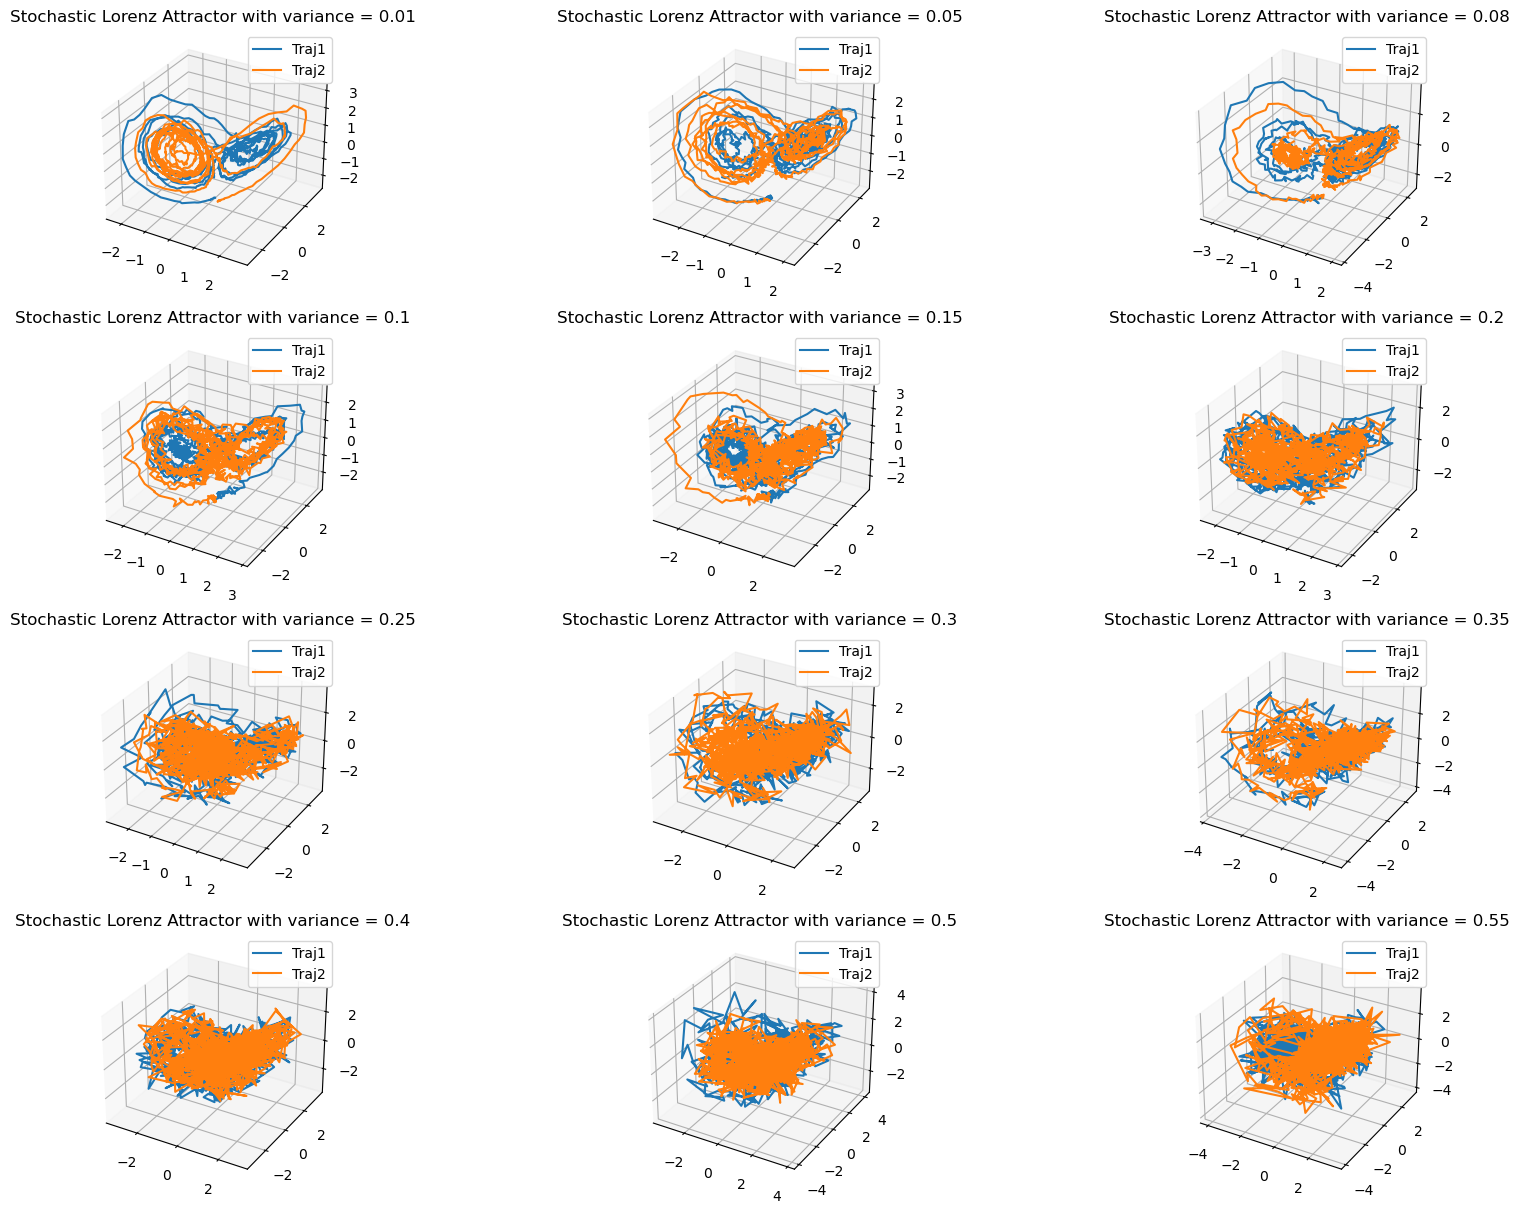

In [201]:
obtain_attractor_with_std(stds=[0.01, 0.05, 0.08, 0.10, 0.15, 0.20, 0.25, 0.30,0.35, 0.40, 0.50, 0.55])